In [32]:
from os.path import abspath
from pyspark.sql import SparkSession

# set default location for [spark-warehouse]
warehouse_location = abspath('spark-warehouse')

In [33]:
spark = (
    SparkSession
    .builder
    .appName("Delta Lake")
    .config("spark.jars.packages", "org.apache.spark:spark-avro_2.12:3.1.1,io.delta:delta-core_2.12:1.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.1.1")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    .config("spark.sql.debug.maxToStringFields","1000")
    .config("spark.kryoserializer.buffer.max","128m")
    .config("spark.driver.memory", "16G")
    .enableHiveSupport()
    .getOrCreate()
)
spark.sparkContext.setLogLevel("WARN")

In [34]:
conf = spark.sparkContext._jsc.hadoopConfiguration()
conf.set("fs.gs.project.id", "hering-datalake-prod")
conf.set("fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem")
conf.set("fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS")

---

In [35]:
from pyspark.sql.avro.functions import from_avro, to_avro
import pyspark.sql.functions as f
from urllib.request import urlopen
import json
from pyspark.sql.types import StringType
from dateutil import parser
from pyspark.sql import DataFrame as SparkDataFrame,DataFrame
from datetime import datetime
from typing import List
from dateutil import parser
import json
import pyspark.sql.functions as f
from pyspark.sql.types import StructField, StructType, StringType, DoubleType, BinaryType, IntegerType, TimestampType
from pyspark.sql import Column
from pyspark.sql import DataFrame as SparkDataFrame,DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from delta.tables import DeltaTable

In [36]:

def generete_symlink_manifest(spark:SparkSession, bucket:str) -> None:
        """
        Gera o arquivo symlink manifest para a tabela Delta do bucket de referencia
        """
        delta_table = DeltaTable.forPath(spark, bucket)
        delta_table.generate("symlink_format_manifest")


def path_exists(path, spark:SparkSession):
        """
        Dado um caminho verifica se existe ou não
        """
        sc = spark.sparkContext
        fs = sc._jvm.org.apache.hadoop.fs.FileSystem.get(
            sc._jvm.java.net.URI.create("gs://" + path.split("/")[2]),
            sc._jsc.hadoopConfiguration(),
        )
        return fs.exists(sc._jvm.org.apache.hadoop.fs.Path(path))


def last_date(delta_path:str, spark:SparkSession):
        """
        Retorna a data (timestamp_kafka) do último registro da tabela Delta
        """
        if not path_exists(delta_path + 'job_control/last_date', spark):
            try:
                df_temp = (
                    spark
                    .read
                    .format("delta")
                    .load(delta_path)
                )

                list_result = (
                    df_temp
                    .agg({"timestamp_kafka": "max"}).collect()
                )

                last_date = str(list_result[0].asDict()['max(timestamp_kafka)'])
                snapshot_flag = False
            except:
                snapshot_flag = True
                last_date = ('01-01-2021 12:00AM')

            df = spark.read.json(spark.sparkContext.parallelize([{'last_date': last_date}]))
            df.write.mode('overwrite').csv(delta_path + 'job_control/last_date', header = 'true')
        else:
            snapshot_flag = False
            df = spark.read.format("csv").load(delta_path + 'job_control/last_date', header = 'true')
            last_date = df.collect()[0].asDict()['last_date']

        return parser.parse(last_date),snapshot_flag


def update_last_date(delta_path:str, df:DataFrame, spark:SparkSession):
        """
        Atualiza a data (timestamp_kafka) do último registro da tabela Delta
        """
        list_result = (
            df
            .agg({"timestamp_kafka": "max"}).collect()
        )

        last_date = str(list_result[0].asDict()['max(timestamp_kafka)'])
        df = spark.read.json(spark.sparkContext.parallelize([{'last_date': last_date}]))
        df.write.mode('overwrite').csv(delta_path + 'job_control/last_date', header = 'true')

        return last_date

def get_operations_counts(df:DataFrame, spark:SparkSession):
        """
        Retorna o número de registros de cada operação kafka (__op)
        """
        op_count_list =(
            df
            .groupBy('__op')
            .count()
            .collect()
        )
        
        new_data_count = 0
        updating_data_count = 0
        deleting_data_count = 0

        if len(op_count_list) > 0:
            for i in op_count_list:
                dic_temp = i.asDict()
                if (dic_temp['__op'] == 'r'):
                    new_data_count = new_data_count + dic_temp['count']
                elif (dic_temp['__op'] != 'r'):
                    updating_data_count = updating_data_count + dic_temp['count']
                elif (dic_temp['__op'] == 'd'):
                    deleting_data_count = deleting_data_count + dic_temp['count']

        new_total_data_count = new_data_count + updating_data_count + deleting_data_count
        
        return new_total_data_count, new_data_count, updating_data_count, deleting_data_count


def get_data(spark:SparkSession, bucket:str, date_colunm_name:str, date_begin:datetime, source_format:str='delta', is_landing:bool=False):
        """
        Carrega Dataframe filtrando os dados do bucket de referência conforme 
        data de início enviada no parametro

        :param str date_begin: Data de início para filtro dos dados
        """
        if is_landing:
            schema = StructType() \
                    .add("key",BinaryType(),True) \
                    .add("value",BinaryType(),True) \
                    .add("topic",StringType(),True) \
                    .add("partition",IntegerType(),True) \
                    .add("offset",StringType(),True) \
                    .add("timestamp",TimestampType(),True)
            df = (
                spark
                .read
                .format(source_format)
                .schema(schema)
                .load(bucket)
                .where(
                    (f.col("year")>date_begin.year)|
                    (
                        (f.col("year")==date_begin.year)&
                        (
                        (f.col("month")>date_begin.month)|
                        (
                            (f.col("month")==date_begin.month)&
                            (
                            (f.col("day")>date_begin.day)|
                            (
                                (f.col("day")==date_begin.day)&
                                (f.col("hour")>=date_begin.hour)&
                                (f.col(date_colunm_name)>date_begin)
                            )
                            )
                        )
                        )          
                    ) 
                )
            )
        else:
            df = (
                spark
                .read
                .format(source_format)
                .load(bucket)
                .where(
                    (f.col("year")>date_begin.year)|
                    (
                        (f.col("year")==date_begin.year)&
                        (
                        (f.col("month")>date_begin.month)|
                        (
                            (f.col("month")==date_begin.month)&
                            (
                            (f.col("day")>date_begin.day)|
                            (
                                (f.col("day")==date_begin.day)&
                                (f.col("hour")>=date_begin.hour)&
                                (f.col(date_colunm_name)>date_begin)
                            )
                            )
                        )
                        )          
                    ) 
                )
            )
        return df


def write_new_data(spark:SparkSession, df:DataFrame, bucket:str, destination_format:str='delta'):
        """
        Escreve no bucket de destino os dados novos, cuja a operação kafka é 'r'
        """
        df_r = df.where((f.col('__op') == 'r'))
        (
            df_r
            .write
            .format(destination_format)
            .mode("append")
            .option("checkpointLocation", bucket + "checkpoint")
            .save(bucket)
        )
        
        return True


def update_new_data(spark:SparkSession, df:DataFrame, bucket:str, pk:list=['pk_single']):
        """
        Escreve no bucket de destino os dados novos, cuja a operação kafka é 'c' e
        atualiza os dados existentes, cuja a operação kafka é 'u' ou 'd'
        """
        table = DeltaTable.forPath(spark, bucket)
        df_table_u = df.where((f.col('__op') != 'r'))
        df_table_u_unique = df_table_u.orderBy('timestamp_kafka', ascending = False).dropDuplicates(pk)
        merge_string = 'destination.' + pk[0] + ' = updates.' + pk[0]
        (
            table.alias('destination')
            .merge(df_table_u_unique.alias('updates'), merge_string)
            .whenMatchedUpdateAll()
            .whenNotMatchedInsertAll()
            .execute()
        )
        
        return True


def delete_new_data(spark:SparkSession, bucket:str):
        """
        Deleta da tabela delta, no bucket de destino, os dados cuja a operação kafka é 'd'
        """
        table = DeltaTable.forPath(spark, bucket)
        table.delete(f.col('__op') == 'd')
        
        return True


def flatten_df(nested_df):
        """
        Retorna um dataframe com as colunas de um dataframe aninhado
        """
        flat_cols = [c[0] for c in nested_df.dtypes if c[1][:6] != 'struct']
        nested_cols = [c[0] for c in nested_df.dtypes if c[1][:6] == 'struct']

        flat_df = nested_df.select(flat_cols +
                                [f.col(nc+'.'+c)
                                    for nc in nested_cols
                                    for c in nested_df.select(nc+'.*').columns])
        return flat_df


def write_bronze_table(df:DataFrame, bucket:str):
        """
        Escreve no bucket de destino a tabela delta bronze
        """
        (
            df
            .write
            .partitionBy("year", "month", "day", "hour")
            .format("delta")
            .mode("append")
            .option("checkpointLocation", bucket + "checkpoint")
            .save(bucket)
        )

        return True

def get_schema(df:DataFrame):
    json_str = df.limit(1).toPandas()['fixedValue'][0]
    json_fields = json.loads(json_str)['schema']['fields']
    struct_fields = []
    for field in json_fields:
        struct_fields.append(StructField(field['field'], StringType()))
        
    return StructType(struct_fields)

def decode_data_frame(df:DataFrame, schema:StructType):
    df_decoded = ( 
        df
        .withColumn('fixedValue', f.col("value").cast("string"))
        .select(f.get_json_object('fixedValue',"$.payload").alias('payload'), 'timestamp_kafka')
        .withColumnRenamed('timestamp', 'timestamp_kafka')
        .select(f.from_json(f.col('payload'), schema).alias("DF"), 'timestamp_kafka')
        .select("DF.*" , 'timestamp_kafka')
    )
    
    return df_decoded

In [37]:

#PATH SILVER ZONE
SILVER_PATH_VENDA = 'gs://hering-datalake-prod-southamerica-east1-bucket-silver-zone/oto/bnsvher602/db_mobile/dbo/venda/'
SILVER_PATH_VENDA_ITEM = 'gs://hering-datalake-prod-southamerica-east1-bucket-silver-zone/oto/bnsvher602/db_mobile/dbo/venda_item/'
SILVER_PATH_FILIAL = 'gs://hering-datalake-prod-southamerica-east1-bucket-silver-zone/oto/bnsvher602/db_mobile/dbo/filial/'
SILVER_PATH_REDE_LOJA = 'gs://hering-datalake-prod-southamerica-east1-bucket-silver-zone/oto/bnsvher602/db_mobile/dbo/rede_loja/'
SILVER_PATH_EMPRESA = 'gs://hering-datalake-prod-southamerica-east1-bucket-silver-zone/oto/bnsvher602/db_mobile/dbo/empresa/'
SILVER_PATH_PRODUTO_BARRA = 'gs://hering-datalake-prod-southamerica-east1-bucket-silver-zone/oto/bnsvher602/db_mobile/dbo/mb_produtos_barra/'
SILVER_PATH_VENDEDOR_LOJA = 'gs://hering-datalake-prod-southamerica-east1-bucket-silver-zone/oto/bnsvher602/db_mobile/dbo/vendedor_loja/'
SILVER_PATH_FILIAL_PONTO = 'gs://hering-datalake-prod-southamerica-east1-bucket-silver-zone/oto/bnsvher602/db_mobile/dbo/filial_ponto/'
SILVER_PATH_SITE = 'gs://hering-datalake-prod-southamerica-east1-bucket-silver-zone/oto/bnsvher602/db_mobile/dbo/site/'
SILVER_PATH_GERENTE_REGIONAL = 'gs://hering-datalake-prod-southamerica-east1-bucket-silver-zone/oto/bnsvher602/db_mobile/dbo/gerente_regional/'
SILVER_PATH_CONSULTOR = 'gs://hering-datalake-prod-southamerica-east1-bucket-silver-zone/oto/bnsvher602/db_mobile/dbo/consultor/'

SILVER_PATH_PRODUTOS =  'gs://hering-datalake-prod-southamerica-east1-bucket-silver-zone/oto/bnsvher602/linx_db/dbo/produtos/'
SILVER_PATH_PRODUTOS_BARRA_LINX = 'gs://hering-datalake-prod-southamerica-east1-bucket-silver-zone/oto/bnsvher602/linx_db/dbo/produtos_barra/'
SILVER_PATH_HR_WEB_CATALOGO_SKU =  'gs://hering-datalake-prod-southamerica-east1-bucket-silver-zone/oto/bnsvher602/linx_db/dbo/hr_web_catalogo_sku/'
SILVER_PATH_HR_WEB_CATALOGO_FOTO =  'gs://hering-datalake-prod-southamerica-east1-bucket-silver-zone/oto/bnsvher602/linx_db/dbo/hr_web_catalogo_foto/'
SILVER_PATH_PRODUTO_CORES =  'gs://hering-datalake-prod-southamerica-east1-bucket-silver-zone/oto/bnsvher602/linx_db/dbo/produto_cores/'

SILVER_PATH_BASE_CLIENTES =  'gs://hering-datalake-prod-southamerica-east1-bucket-silver-zone/oto/bnsvher361/db_analise/crm/tb_base_clientes/'
SILVER_PATH_SEGMENTACAO =  'gs://hering-datalake-prod-southamerica-east1-bucket-silver-zone/oto/bnsvher361/db_analise/dbo/tabela_segmentacao/'


#PATH GOLD ZONE
GOLD_PATH_CUSTOMERS = 'gs://hering-datalake-prod-southamerica-east1-bucket-gold-zone/oto/homol/customers'
GOLD_PATH_ORDERS = 'gs://hering-datalake-prod-southamerica-east1-bucket-gold-zone/oto/homol/orders/'
GOLD_PATH_ORDERS_ITEMS = 'gs://hering-datalake-prod-southamerica-east1-bucket-gold-zone/oto/homol/orders_items/'
GOLD_PATH_PRODUCTS = 'gs://hering-datalake-prod-southamerica-east1-bucket-gold-zone/oto/homol/products/'
GOLD_PATH_SELLERS = 'gs://hering-datalake-prod-southamerica-east1-bucket-gold-zone/oto/homol/sellers/'
GOLD_PATH_STORES = 'gs://hering-datalake-prod-southamerica-east1-bucket-gold-zone/oto/homol/stores/'

GOLD_PATH_OTO_DZARM = 'gs://hering-datalake-prod-southamerica-east1-bucket-gold-zone/oto/homol/dzarm/'
GOLD_PATH_OTO_HERING_HMG = 'gs://hering-datalake-prod-southamerica-east1-bucket-gold-zone/oto/homol/hering_hmg/'
GOLD_PATH_OTO_HERING_KIDS = 'gs://hering-datalake-prod-southamerica-east1-bucket-gold-zone/oto/homol/hering_kids/'
GOLD_PATH_OTO_HERING_OUTLETS = 'gs://hering-datalake-prod-southamerica-east1-bucket-gold-zone/oto/homol/hering_outlets/'

In [38]:
base_clientes = DeltaTable.forPath(spark, SILVER_PATH_BASE_CLIENTES)
segmenta = DeltaTable.forPath(spark, SILVER_PATH_SEGMENTACAO)
sql = '''
            -----------------------------DZARM----------------------------------
            SELECT
            sha2(TRIM(BC.cpf_cnpj_cliente),256) AS CUSTOMER_ID
            ,sha2(TRIM(BC.cpf_cnpj_cliente),256) AS DOCUMENT_NUMBER
            ,sha2(TRIM(BC.cpf_cnpj_cliente),256) AS MKT_CLOUD_ID
            ,TRIM(IFNULL(email,'')) AS EMAIL
            ,CASE WHEN TRIM(flg_black_list_email) = 0 THEN '1' ELSE '0' END AS EMAIL_PERMISSION
            ,TRIM(IFNULL(celular,'')) AS MOBILE_NUMBER
            ,CASE WHEN TRIM(flg_black_list_sms) = 0 THEN '1' ELSE '0' END AS MOBILE_PERMISSION
            ,CASE WHEN TRIM(flg_black_list_whatsapp) = 0 THEN '1' ELSE '0' END AS WHATSAPP_PERMISSION
            ,TRIM(IFNULL(REPLACE(nome_primeiro, '"', ''),'')) AS FIRST_NAME
            ,TRIM(IFNULL(REPLACE(nome_ultimo, '"', ''),'')) AS LAST_NAME
            ,date_format(dt_cad_cliente, 'yyyy-MM-dd') AS CREATE_DATE
            ,'BRASIL' AS COUNTRY
            ,TRIM(IFNULL(uf,'')) AS STATE
            ,TRIM(IFNULL(cidade,'')) AS CITY
            ,TRIM(IFNULL(cep,'')) AS ZIPCODE
            ,'' AS ADDRESS
            ,'' AS ADDRESS_N
            ,'' AS ADDRESS_COMPLEMENT
            ,TRIM(IFNULL(genero,'')) AS GENDER
            ,IFNULL(date_format( dt_nasc_cliente,'yyyy-MM-dd'),'') AS DATE_BIRTH
            ,TRIM(IFNULL(dpc,'')) AS FIRST_ORDER
            ,IFNULL(CASE WHEN loja_preferencial = 0 THEN 0 ELSE (loja_preferencial-1000) END,'')  AS PREF_STORE
            ,TRIM(IFNULL(SEG_CICLO,'')) AS RFV
            ,'CRM' AS DATA_SOURCE
            ,marca_tratado AS MARCA_TRATADO
            --,__op
            ,dt_cad_cliente as timestamp_kafka
            ,SA.MISSAO_ADULTO AS MISSAO
            ,SA.FLG_PROMO AS FLG_PROMO
            FROM  view_tb_base_clientes AS BC
            LEFT JOIN view_segmentacoes_analytics AS SA ON BC.cpf_cnpj_cliente = SA.CPF_CNPJ_CLIENTE and BC.marca_tratado = SA.MARCA
            WHERE marca_tratado = 'DZARM' and BC.dt_cad_cliente < '2022-07-27'

            UNION ALL
            -----------------------------HERING STORE----------------------------------
            SELECT
            sha2(TRIM(BC.cpf_cnpj_cliente),256) AS CUSTOMER_ID
            ,sha2(TRIM(BC.cpf_cnpj_cliente),256) AS DOCUMENT_NUMBER
            ,sha2(TRIM(BC.cpf_cnpj_cliente),256) AS MKT_CLOUD_ID
            ,TRIM(IFNULL(email,'')) AS EMAIL
            ,CASE WHEN TRIM(flg_black_list_email) = 0 THEN '1' ELSE '0' END AS EMAIL_PERMISSION
            ,TRIM(IFNULL(celular,'')) AS MOBILE_NUMBER
            ,CASE WHEN TRIM(flg_black_list_sms) = 0 THEN '1' ELSE '0' END AS MOBILE_PERMISSION
            ,CASE WHEN TRIM(flg_black_list_whatsapp) = 0 THEN '1' ELSE '0' END AS WHATSAPP_PERMISSION
            ,TRIM(IFNULL(REPLACE(nome_primeiro, '"', ''),'')) AS FIRST_NAME
            ,TRIM(IFNULL(REPLACE(nome_ultimo, '"', ''),'')) AS LAST_NAME
            ,date_format(dt_cad_cliente, 'yyyy-MM-dd') AS CREATE_DATE
            ,'BRASIL' AS COUNTRY
            ,TRIM(IFNULL(uf,'')) AS STATE
            ,TRIM(IFNULL(cidade,'')) AS CITY
            ,TRIM(IFNULL(cep,'')) AS ZIPCODE
            ,'' AS ADDRESS
            ,'' AS ADDRESS_N
            ,'' AS ADDRESS_COMPLEMENT
            ,TRIM(IFNULL(genero,'')) AS GENDER
            ,IFNULL(date_format( dt_nasc_cliente,'yyyy-MM-dd'),'') AS DATE_BIRTH
            ,TRIM(IFNULL(dpc,'')) AS FIRST_ORDER
            ,IFNULL(CASE WHEN loja_preferencial = 0 THEN 0 ELSE (loja_preferencial-1000) END,'')  AS PREF_STORE
            ,TRIM(IFNULL(SEG_CICLO,'')) AS RFV
            ,'CRM' AS DATA_SOURCE
            ,marca_tratado AS MARCA_TRATADO
            --,__op
            ,dt_cad_cliente as timestamp_kafka
            ,SA.MISSAO_ADULTO AS MISSAO
            ,SA.FLG_PROMO AS FLG_PROMO
            FROM  view_tb_base_clientes AS BC
            LEFT JOIN view_segmentacoes_analytics AS SA ON BC.cpf_cnpj_cliente = SA.CPF_CNPJ_CLIENTE and BC.marca_tratado = SA.MARCA
            WHERE marca_tratado = 'HERING STORE'and BC.dt_cad_cliente < '2022-07-27'

            UNION ALL
            -----------------------------HERING KIDS (DIFERENCIA DO STORE PELO JOIN, SOMENTE)----------------------------------
            SELECT
            sha2(TRIM(BC.cpf_cnpj_cliente),256) AS CUSTOMER_ID
            ,sha2(TRIM(BC.cpf_cnpj_cliente),256) AS DOCUMENT_NUMBER
            ,sha2(TRIM(BC.cpf_cnpj_cliente),256) AS MKT_CLOUD_ID
            ,TRIM(IFNULL(email,'')) AS EMAIL
            ,CASE WHEN TRIM(flg_black_list_email) = 0 THEN '1' ELSE '0' END AS EMAIL_PERMISSION
            ,TRIM(IFNULL(celular,'')) AS MOBILE_NUMBER
            ,CASE WHEN TRIM(flg_black_list_sms) = 0 THEN '1' ELSE '0' END AS MOBILE_PERMISSION
            ,CASE WHEN TRIM(flg_black_list_whatsapp) = 0 THEN '1' ELSE '0' END AS WHATSAPP_PERMISSION
            ,TRIM(IFNULL(REPLACE(nome_primeiro, '"', ''),'')) AS FIRST_NAME
            ,TRIM(IFNULL(REPLACE(nome_ultimo, '"', ''),'')) AS LAST_NAME
            ,date_format(dt_cad_cliente, 'yyyy-MM-dd') AS CREATE_DATE
            ,'BRASIL' AS COUNTRY
            ,TRIM(IFNULL(uf,'')) AS STATE
            ,TRIM(IFNULL(cidade,'')) AS CITY
            ,TRIM(IFNULL(cep,'')) AS ZIPCODE
            ,'' AS ADDRESS
            ,'' AS ADDRESS_N
            ,'' AS ADDRESS_COMPLEMENT
            ,TRIM(IFNULL(genero,'')) AS GENDER
            ,IFNULL(date_format( dt_nasc_cliente,'yyyy-MM-dd'),'') AS DATE_BIRTH
            ,TRIM(IFNULL(dpc,'')) AS FIRST_ORDER
            ,IFNULL(CASE WHEN loja_preferencial = 0 THEN 0 ELSE (loja_preferencial-1000) END,'')  AS PREF_STORE
            ,TRIM(IFNULL(SEG_CICLO,'')) AS RFV
            ,'CRM' AS DATA_SOURCE
            ,'HERING KIDS' AS MARCA_TRATADO
            --,__op
            ,dt_cad_cliente as timestamp_kafka
            ,CASE WHEN SA.MISSAO_INFANTIL IS NOT NULL THEN SA.MISSAO_INFANTIL ELSE SA.MISSAO_ADULTO END AS MISSAO
            ,SA.FLG_PROMO AS FLG_PROMO
            FROM  view_tb_base_clientes AS BC
            LEFT JOIN view_segmentacoes_analytics AS SA ON BC.cpf_cnpj_cliente = SA.CPF_CNPJ_CLIENTE and BC.marca_tratado = SA.MARCA
            WHERE marca_tratado = 'HERING STORE' and BC.dt_cad_cliente < '2022-07-27'

            UNION ALL
            -----------------------------HERING OUTLET----------------------------------
            SELECT
            sha2(TRIM(BC.cpf_cnpj_cliente),256) AS CUSTOMER_ID
            ,sha2(TRIM(BC.cpf_cnpj_cliente),256) AS DOCUMENT_NUMBER
            ,sha2(TRIM(BC.cpf_cnpj_cliente),256) AS MKT_CLOUD_ID
            ,TRIM(IFNULL(email,'')) AS EMAIL
            ,CASE WHEN TRIM(flg_black_list_email) = 0 THEN '1' ELSE '0' END AS EMAIL_PERMISSION
            ,TRIM(IFNULL(celular,'')) AS MOBILE_NUMBER
            ,CASE WHEN TRIM(flg_black_list_sms) = 0 THEN '1' ELSE '0' END AS MOBILE_PERMISSION
            ,CASE WHEN TRIM(flg_black_list_whatsapp) = 0 THEN '1' ELSE '0' END AS WHATSAPP_PERMISSION
            ,TRIM(IFNULL(REPLACE(nome_primeiro, '"', ''),'')) AS FIRST_NAME
            ,TRIM(IFNULL(REPLACE(nome_ultimo, '"', ''),'')) AS LAST_NAME
            ,date_format(dt_cad_cliente, 'yyyy-MM-dd' ) AS CREATE_DATE
            ,'BRASIL' AS COUNTRY
            ,TRIM(IFNULL(uf,'')) AS STATE
            ,TRIM(IFNULL(cidade,'')) AS CITY
            ,TRIM(IFNULL(cep,'')) AS ZIPCODE
            ,'' AS ADDRESS
            ,'' AS ADDRESS_N
            ,'' AS ADDRESS_COMPLEMENT
            ,TRIM(IFNULL(genero,'')) AS GENDER
            ,IFNULL(date_format( dt_nasc_cliente,'yyyy-MM-dd'),'') AS DATE_BIRTH
            ,TRIM(IFNULL(dpc,'')) AS FIRST_ORDER
            ,IFNULL(CASE WHEN loja_preferencial = 0 THEN 0 ELSE (loja_preferencial-1000) END,'')  AS PREF_STORE
            ,TRIM(IFNULL(SEG_CICLO,'')) AS RFV
            ,'CRM' AS DATA_SOURCE
            ,marca_tratado AS MARCA_TRATADO
            --,__op
            ,dt_cad_cliente as timestamp_kafka
            ,SA.MISSAO_ADULTO AS MISSAO
            ,SA.FLG_PROMO AS FLG_PROMO
            FROM  view_tb_base_clientes AS BC
            LEFT JOIN view_segmentacoes_analytics AS SA ON BC.cpf_cnpj_cliente = SA.CPF_CNPJ_CLIENTE and BC.marca_tratado = SA.MARCA
            WHERE marca_tratado = 'HERING OUTLET' and BC.dt_cad_cliente < '2022-07-27'

            UNION ALL
            -----------------------------TODOS----------------------------------
            SELECT
            '00000000000' AS CUSTOMER_ID
            ,'00000000000' AS  DOCUMENT_NUMBER
            ,'00000000000' AS MKT_CLOUD_ID
            ,'' AS EMAIL
            ,0 AS EMAIL_PERMISSION
            ,'' AS MOBILE_NUMBER
            ,0 AS MOBILE_PERMISSION
            ,0 AS WHATSAPP_PERMISSION
            ,'' AS FIRST_NAME
            ,'' AS LAST_NAME
            ,'1900-01-01' AS CREATE_DATE
            ,'BRASIL' AS COUNTRY
            ,'' AS STATE
            ,'' AS CITY
            ,'' AS ZIPCODE
            ,'' AS ADDRESS
            ,'' AS ADDRESS_N
            ,'' AS ADDRESS_COMPLEMENT
            ,'' AS GENDER
            ,'1900-01-01' AS DATE_BIRTH
            ,'1900-01-01' AS FIRST_ORDER
            ,'' AS PREF_STORE
            ,'' AS RFV
            ,'CRM' AS DATA_SOURCE
            ,'TODOS' AS MARCA_TRATADO
            --,'r' AS __op
            ,cast('20-05-14 08:48:49.063' as timestamp) AS timestamp_kafka
            ,'' AS MISSAO
            ,'' AS FLG_PROMO
    '''

sql2 = '''

            SELECT
            sha2(TRIM(BC.cpf_cnpj_cliente),256) AS CUSTOMER_ID
            ,sha2(TRIM(BC.cpf_cnpj_cliente),256) AS DOCUMENT_NUMBER
            ,sha2(TRIM(BC.cpf_cnpj_cliente),256) AS MKT_CLOUD_ID
            ,TRIM(IFNULL(email,'')) AS EMAIL
            ,CASE WHEN TRIM(flg_black_list_email) = 0 THEN '1' ELSE '0' END AS EMAIL_PERMISSION
            ,TRIM(IFNULL(celular,'')) AS MOBILE_NUMBER
            ,CASE WHEN TRIM(flg_black_list_sms) = 0 THEN '1' ELSE '0' END AS MOBILE_PERMISSION
            ,CASE WHEN TRIM(flg_black_list_whatsapp) = 0 THEN '1' ELSE '0' END AS WHATSAPP_PERMISSION
            ,TRIM(IFNULL(REPLACE(nome_primeiro, '"', ''),'')) AS FIRST_NAME
            ,TRIM(IFNULL(REPLACE(nome_ultimo, '"', ''),'')) AS LAST_NAME
            ,date_format(dt_cad_cliente, 'yyyy-MM-dd' ) AS CREATE_DATE
            ,'BRASIL' AS COUNTRY
            ,TRIM(IFNULL(uf,'')) AS STATE
            ,TRIM(IFNULL(cidade,'')) AS CITY
            ,TRIM(IFNULL(cep,'')) AS ZIPCODE
            ,'' AS ADDRESS
            ,'' AS ADDRESS_N
            ,'' AS ADDRESS_COMPLEMENT
            ,TRIM(IFNULL(genero,'')) AS GENDER
            ,IFNULL(date_format( dt_nasc_cliente,'yyyy-MM-dd'),'') AS DATE_BIRTH
            ,TRIM(IFNULL(dpc,'')) AS FIRST_ORDER
            ,IFNULL(CASE WHEN loja_preferencial = 0 THEN 0 ELSE (loja_preferencial-1000) END,'')  AS PREF_STORE
            ,TRIM(IFNULL(SEG_CICLO,'')) AS RFV
            ,'CRM' AS DATA_SOURCE
            ,marca_tratado AS MARCA_TRATADO
            --,__op
            ,dt_cad_cliente as timestamp_kafka
            ,SA.MISSAO_ADULTO AS MISSAO
            ,SA.FLG_PROMO AS FLG_PROMO
            FROM  view_tb_base_clientes AS BC
            LEFT JOIN view_segmentacoes_analytics AS SA ON BC.cpf_cnpj_cliente = SA.CPF_CNPJ_CLIENTE and BC.marca_tratado = SA.MARCA

'''

In [39]:
base_clientes.toDF().createOrReplaceTempView("view_tb_base_clientes")
segmenta.toDF().createOrReplaceTempView("view_segmentacoes_analytics")


In [9]:
sql3 = '''
select count(*) from view_tb_base_clientes AS BC
LEFT JOIN view_segmentacoes_analytics AS SA 
ON BC.cpf_cnpj_cliente = SA.CPF_CNPJ_CLIENTE and 
BC.marca_tratado = SA.MARCA'''
spark.sql(sql3).show()

+--------+
|count(1)|
+--------+
|11202650|
+--------+



In [10]:
spark.sql(sql).count()

21236971

In [22]:
sqlx = '''
            -----------------------------DZARM----------------------------------
            SELECT
            sha2(TRIM(BC.cpf_cnpj_cliente),256) AS CUSTOMER_ID
            ,sha2(TRIM(BC.cpf_cnpj_cliente),256) AS DOCUMENT_NUMBER
            ,sha2(TRIM(BC.cpf_cnpj_cliente),256) AS MKT_CLOUD_ID
            ,TRIM(IFNULL(email,'')) AS EMAIL
            ,CASE WHEN TRIM(flg_black_list_email) = 0 THEN '1' ELSE '0' END AS EMAIL_PERMISSION
            ,TRIM(IFNULL(celular,'')) AS MOBILE_NUMBER
            ,CASE WHEN TRIM(flg_black_list_sms) = 0 THEN '1' ELSE '0' END AS MOBILE_PERMISSION
            ,CASE WHEN TRIM(flg_black_list_whatsapp) = 0 THEN '1' ELSE '0' END AS WHATSAPP_PERMISSION
            ,TRIM(IFNULL(REPLACE(nome_primeiro, '"', ''),'')) AS FIRST_NAME
            ,TRIM(IFNULL(REPLACE(nome_ultimo, '"', ''),'')) AS LAST_NAME
            ,date_format(dt_cad_cliente, 'yyyy-MM-dd') AS CREATE_DATE
            ,'BRASIL' AS COUNTRY
            ,TRIM(IFNULL(uf,'')) AS STATE
            ,TRIM(IFNULL(cidade,'')) AS CITY
            ,TRIM(IFNULL(cep,'')) AS ZIPCODE
            ,'' AS ADDRESS
            ,'' AS ADDRESS_N
            ,'' AS ADDRESS_COMPLEMENT
            ,TRIM(IFNULL(genero,'')) AS GENDER
            ,IFNULL(date_format( dt_nasc_cliente,'yyyy-MM-dd'),'') AS DATE_BIRTH
            ,TRIM(IFNULL(dpc,'')) AS FIRST_ORDER
            ,IFNULL(CASE WHEN loja_preferencial = 0 THEN 0 ELSE (loja_preferencial-1000) END,'')  AS PREF_STORE
            ,TRIM(IFNULL(SEG_CICLO,'')) AS RFV
            ,'CRM' AS DATA_SOURCE
            ,marca_tratado AS MARCA_TRATADO
            --,__op
            ,dt_cad_cliente as timestamp_kafka
            ,SA.MISSAO_ADULTO AS MISSAO
            ,SA.FLG_PROMO AS FLG_PROMO
            FROM  view_tb_base_clientes AS BC
            LEFT JOIN view_segmentacoes_analytics AS SA ON BC.cpf_cnpj_cliente = SA.CPF_CNPJ_CLIENTE and BC.marca_tratado = SA.MARCA
            WHERE marca_tratado = 'DZARM'

            UNION ALL
            -----------------------------HERING STORE----------------------------------
            SELECT
            sha2(TRIM(BC.cpf_cnpj_cliente),256) AS CUSTOMER_ID
            ,sha2(TRIM(BC.cpf_cnpj_cliente),256) AS DOCUMENT_NUMBER
            ,sha2(TRIM(BC.cpf_cnpj_cliente),256) AS MKT_CLOUD_ID
            ,TRIM(IFNULL(email,'')) AS EMAIL
            ,CASE WHEN TRIM(flg_black_list_email) = 0 THEN '1' ELSE '0' END AS EMAIL_PERMISSION
            ,TRIM(IFNULL(celular,'')) AS MOBILE_NUMBER
            ,CASE WHEN TRIM(flg_black_list_sms) = 0 THEN '1' ELSE '0' END AS MOBILE_PERMISSION
            ,CASE WHEN TRIM(flg_black_list_whatsapp) = 0 THEN '1' ELSE '0' END AS WHATSAPP_PERMISSION
            ,TRIM(IFNULL(REPLACE(nome_primeiro, '"', ''),'')) AS FIRST_NAME
            ,TRIM(IFNULL(REPLACE(nome_ultimo, '"', ''),'')) AS LAST_NAME
            ,date_format(dt_cad_cliente, 'yyyy-MM-dd') AS CREATE_DATE
            ,'BRASIL' AS COUNTRY
            ,TRIM(IFNULL(uf,'')) AS STATE
            ,TRIM(IFNULL(cidade,'')) AS CITY
            ,TRIM(IFNULL(cep,'')) AS ZIPCODE
            ,'' AS ADDRESS
            ,'' AS ADDRESS_N
            ,'' AS ADDRESS_COMPLEMENT
            ,TRIM(IFNULL(genero,'')) AS GENDER
            ,IFNULL(date_format( dt_nasc_cliente,'yyyy-MM-dd'),'') AS DATE_BIRTH
            ,TRIM(IFNULL(dpc,'')) AS FIRST_ORDER
            ,IFNULL(CASE WHEN loja_preferencial = 0 THEN 0 ELSE (loja_preferencial-1000) END,'')  AS PREF_STORE
            ,TRIM(IFNULL(SEG_CICLO,'')) AS RFV
            ,'CRM' AS DATA_SOURCE
            ,marca_tratado AS MARCA_TRATADO
            --,__op
            ,dt_cad_cliente as timestamp_kafka
            ,SA.MISSAO_ADULTO AS MISSAO
            ,SA.FLG_PROMO AS FLG_PROMO
            FROM  view_tb_base_clientes AS BC
            LEFT JOIN view_segmentacoes_analytics AS SA ON BC.cpf_cnpj_cliente = SA.CPF_CNPJ_CLIENTE and BC.marca_tratado = SA.MARCA
            WHERE marca_tratado = 'HERING STORE'

            UNION ALL
            -----------------------------HERING KIDS (DIFERENCIA DO STORE PELO JOIN, SOMENTE)----------------------------------
            SELECT
            sha2(TRIM(BC.cpf_cnpj_cliente),256) AS CUSTOMER_ID
            ,sha2(TRIM(BC.cpf_cnpj_cliente),256) AS DOCUMENT_NUMBER
            ,sha2(TRIM(BC.cpf_cnpj_cliente),256) AS MKT_CLOUD_ID
            ,TRIM(IFNULL(email,'')) AS EMAIL
            ,CASE WHEN TRIM(flg_black_list_email) = 0 THEN '1' ELSE '0' END AS EMAIL_PERMISSION
            ,TRIM(IFNULL(celular,'')) AS MOBILE_NUMBER
            ,CASE WHEN TRIM(flg_black_list_sms) = 0 THEN '1' ELSE '0' END AS MOBILE_PERMISSION
            ,CASE WHEN TRIM(flg_black_list_whatsapp) = 0 THEN '1' ELSE '0' END AS WHATSAPP_PERMISSION
            ,TRIM(IFNULL(REPLACE(nome_primeiro, '"', ''),'')) AS FIRST_NAME
            ,TRIM(IFNULL(REPLACE(nome_ultimo, '"', ''),'')) AS LAST_NAME
            ,date_format(dt_cad_cliente, 'yyyy-MM-dd') AS CREATE_DATE
            ,'BRASIL' AS COUNTRY
            ,TRIM(IFNULL(uf,'')) AS STATE
            ,TRIM(IFNULL(cidade,'')) AS CITY
            ,TRIM(IFNULL(cep,'')) AS ZIPCODE
            ,'' AS ADDRESS
            ,'' AS ADDRESS_N
            ,'' AS ADDRESS_COMPLEMENT
            ,TRIM(IFNULL(genero,'')) AS GENDER
            ,IFNULL(date_format( dt_nasc_cliente,'yyyy-MM-dd'),'') AS DATE_BIRTH
            ,TRIM(IFNULL(dpc,'')) AS FIRST_ORDER
            ,IFNULL(CASE WHEN loja_preferencial = 0 THEN 0 ELSE (loja_preferencial-1000) END,'')  AS PREF_STORE
            ,TRIM(IFNULL(SEG_CICLO,'')) AS RFV
            ,'CRM' AS DATA_SOURCE
            ,'HERING KIDS' AS MARCA_TRATADO
            --,__op
            ,dt_cad_cliente as timestamp_kafka
            ,CASE WHEN SA.MISSAO_INFANTIL IS NOT NULL THEN SA.MISSAO_INFANTIL ELSE SA.MISSAO_ADULTO END AS MISSAO
            ,SA.FLG_PROMO AS FLG_PROMO
            FROM  view_tb_base_clientes AS BC
            LEFT JOIN view_segmentacoes_analytics AS SA ON BC.cpf_cnpj_cliente = SA.CPF_CNPJ_CLIENTE and BC.marca_tratado = SA.MARCA
            WHERE marca_tratado = 'HERING STORE'

            UNION ALL
            -----------------------------HERING OUTLET----------------------------------
            SELECT
            sha2(TRIM(BC.cpf_cnpj_cliente),256) AS CUSTOMER_ID
            ,sha2(TRIM(BC.cpf_cnpj_cliente),256) AS DOCUMENT_NUMBER
            ,sha2(TRIM(BC.cpf_cnpj_cliente),256) AS MKT_CLOUD_ID
            ,TRIM(IFNULL(email,'')) AS EMAIL
            ,CASE WHEN TRIM(flg_black_list_email) = 0 THEN '1' ELSE '0' END AS EMAIL_PERMISSION
            ,TRIM(IFNULL(celular,'')) AS MOBILE_NUMBER
            ,CASE WHEN TRIM(flg_black_list_sms) = 0 THEN '1' ELSE '0' END AS MOBILE_PERMISSION
            ,CASE WHEN TRIM(flg_black_list_whatsapp) = 0 THEN '1' ELSE '0' END AS WHATSAPP_PERMISSION
            ,TRIM(IFNULL(REPLACE(nome_primeiro, '"', ''),'')) AS FIRST_NAME
            ,TRIM(IFNULL(REPLACE(nome_ultimo, '"', ''),'')) AS LAST_NAME
            ,date_format(dt_cad_cliente, 'yyyy-MM-dd' ) AS CREATE_DATE
            ,'BRASIL' AS COUNTRY
            ,TRIM(IFNULL(uf,'')) AS STATE
            ,TRIM(IFNULL(cidade,'')) AS CITY
            ,TRIM(IFNULL(cep,'')) AS ZIPCODE
            ,'' AS ADDRESS
            ,'' AS ADDRESS_N
            ,'' AS ADDRESS_COMPLEMENT
            ,TRIM(IFNULL(genero,'')) AS GENDER
            ,IFNULL(date_format( dt_nasc_cliente,'yyyy-MM-dd'),'') AS DATE_BIRTH
            ,TRIM(IFNULL(dpc,'')) AS FIRST_ORDER
            ,IFNULL(CASE WHEN loja_preferencial = 0 THEN 0 ELSE (loja_preferencial-1000) END,'')  AS PREF_STORE
            ,TRIM(IFNULL(SEG_CICLO,'')) AS RFV
            ,'CRM' AS DATA_SOURCE
            ,marca_tratado AS MARCA_TRATADO
            --,__op
            ,dt_cad_cliente as timestamp_kafka
            ,SA.MISSAO_ADULTO AS MISSAO
            ,SA.FLG_PROMO AS FLG_PROMO
            FROM  view_tb_base_clientes AS BC
            LEFT JOIN view_segmentacoes_analytics AS SA ON BC.cpf_cnpj_cliente = SA.CPF_CNPJ_CLIENTE and BC.marca_tratado = SA.MARCA
            WHERE marca_tratado = 'HERING OUTLET'

    '''

In [10]:
from datetime import datetime, timedelta
d = datetime.today() - timedelta(days=7)

In [23]:
result_sql = spark.sql(sqlx)

her_store = result_sql.where(result_sql.MARCA_TRATADO.isin('HERING STORE', 'TODOS'))
her_kids = result_sql.where(result_sql.MARCA_TRATADO.isin('HERING KIDS', 'TODOS'))
her_outlet = result_sql.where(result_sql.MARCA_TRATADO.isin('HERING OUTLET', 'TODOS'))
dzarm = result_sql.where(result_sql.MARCA_TRATADO.isin('DZARM', 'TODOS'))

In [24]:
her_store = her_store.where(result_sql.timestamp_kafka > d)

In [25]:
her_store_pd = her_store.toPandas()

In [30]:
her_store_pd[['timestamp_kafka', 'CREATE_DATE']]

timestamp_kafka CREATE_DATE
0          2022-07-26  2022-07-26
1          2022-07-27  2022-07-27
2          2022-07-26  2022-07-26
3          2022-07-28  2022-07-28
4          2022-07-29  2022-07-29
...               ...         ...
22356      2022-07-29  2022-07-29
22357      2022-07-27  2022-07-27
22358      2022-07-26  2022-07-26
22359      2022-07-30  2022-07-30
22360      2022-07-27  2022-07-27

[22361 rows x 2 columns]

In [21]:
her_store_pd.timestamp_kafka.unique()

array([datetime.date(2022, 7, 26), datetime.date(2022, 7, 27),
       datetime.date(2022, 7, 28), datetime.date(2022, 7, 29),
       datetime.date(2022, 7, 30), datetime.date(2022, 7, 31),
       datetime.date(2074, 6, 4), datetime.date(5206, 10, 1),
       datetime.date(2048, 3, 15), datetime.date(2083, 6, 1),
       datetime.date(2084, 1, 1), datetime.date(2093, 5, 6)], dtype=object)

In [31]:
datetime.today() - timedelta(days=4)

datetime.datetime(2022, 7, 28, 21, 8, 15, 659402)

In [42]:
sql3 = '''
select BC.dt_cad_cliente, BC.marca_tratado, count(*)
from view_tb_base_clientes AS BC
LEFT JOIN view_segmentacoes_analytics AS SA 
ON BC.cpf_cnpj_cliente = SA.CPF_CNPJ_CLIENTE and 
BC.marca_tratado = SA.MARCA
WHERE BC.dt_cad_cliente > '2022-07-20' and BC.dt_cad_cliente < '2022-08-10'
GROUP BY BC.dt_cad_cliente, BC.marca_tratado
ORDER BY BC.marca_tratado,BC.dt_cad_cliente;
'''
spark.sql(sql3).show(100)

+--------------+-------------+--------+
|dt_cad_cliente|marca_tratado|count(1)|
+--------------+-------------+--------+
|    2022-07-21|        DZARM|      19|
|    2022-07-22|        DZARM|      16|
|    2022-07-23|        DZARM|      21|
|    2022-07-24|        DZARM|      13|
|    2022-07-25|        DZARM|      13|
|    2022-07-26|        DZARM|      15|
|    2022-07-27|        DZARM|      21|
|    2022-07-28|        DZARM|      18|
|    2022-07-29|        DZARM|      18|
|    2022-07-30|        DZARM|      13|
|    2022-07-31|        DZARM|       2|
|    2022-07-21|HERING OUTLET|     199|
|    2022-07-22|HERING OUTLET|     261|
|    2022-07-23|HERING OUTLET|     464|
|    2022-07-24|HERING OUTLET|     365|
|    2022-07-25|HERING OUTLET|     205|
|    2022-07-26|HERING OUTLET|     266|
|    2022-07-27|HERING OUTLET|     281|
|    2022-07-28|HERING OUTLET|     262|
|    2022-07-29|HERING OUTLET|     313|
|    2022-07-30|HERING OUTLET|     582|
|    2022-07-31|HERING OUTLET|     369|


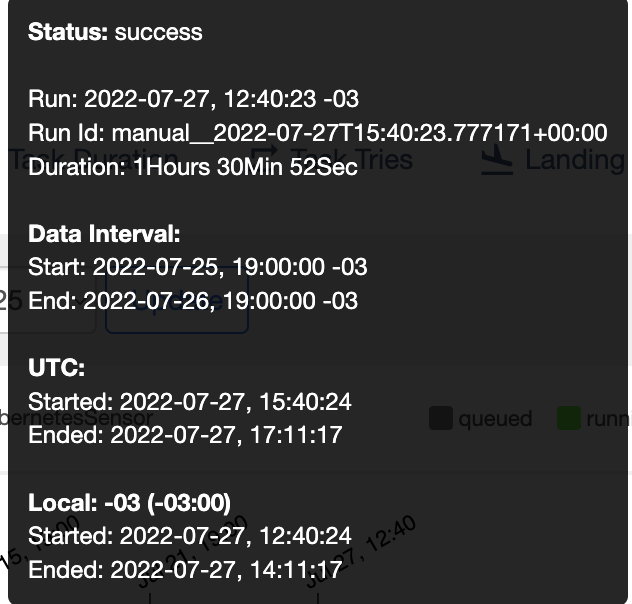

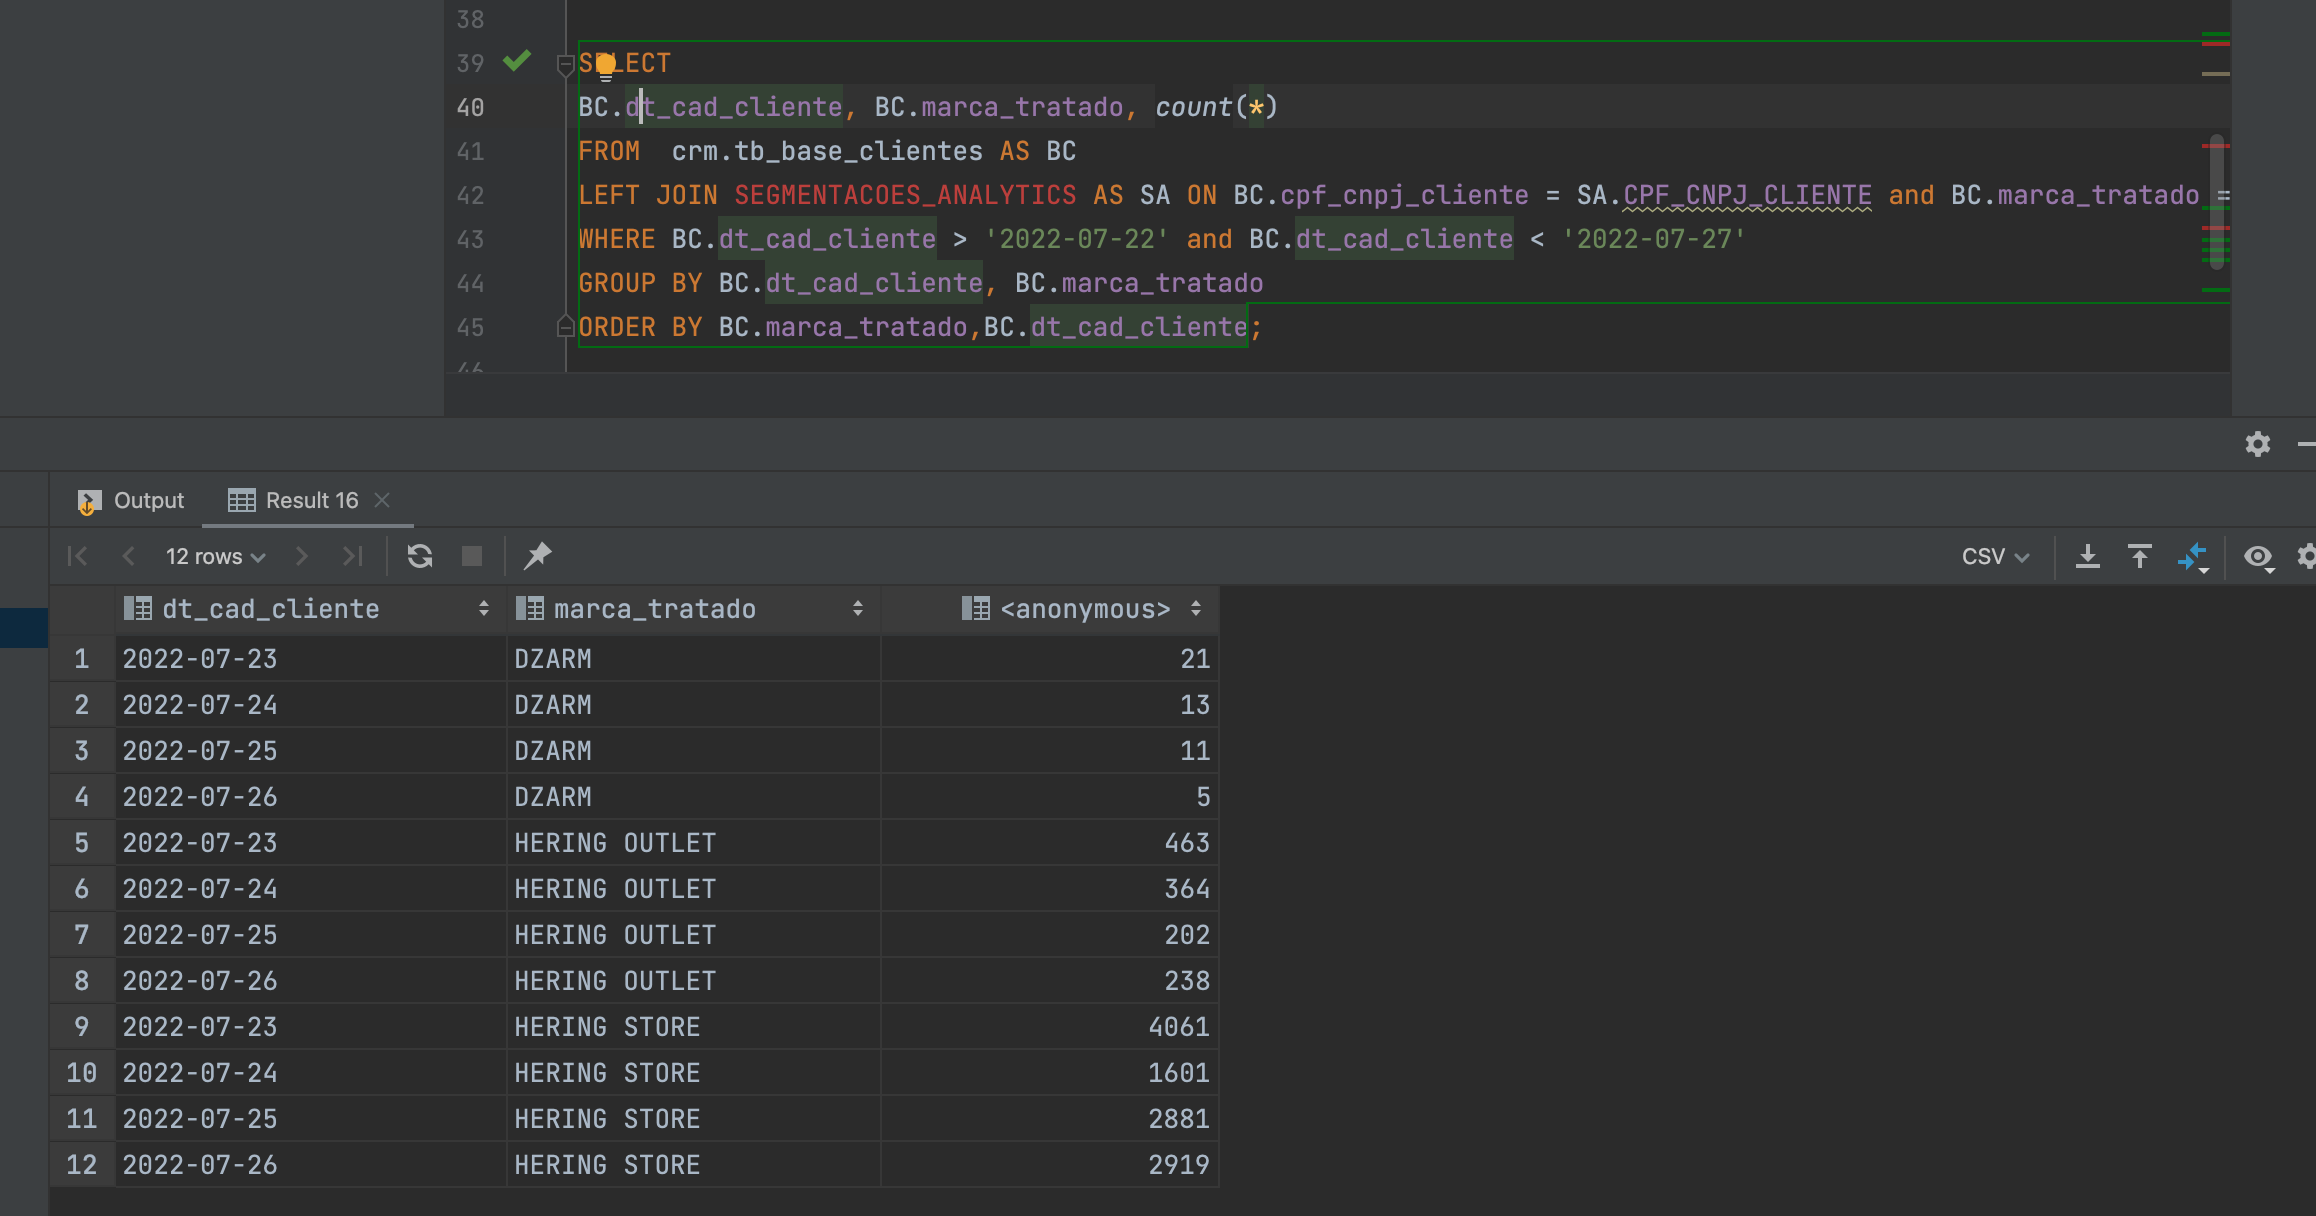

In [ ]:
sql3 = '''
select BC.dt_cad_cliente, BC.marca_tratado, count(*)
from view_tb_base_clientes AS BC
LEFT JOIN view_segmentacoes_analytics AS SA 
ON BC.cpf_cnpj_cliente = SA.CPF_CNPJ_CLIENTE and 
BC.marca_tratado = SA.MARCA
WHERE BC.dt_cad_cliente > '2022-07-22' and BC.dt_cad_cliente < '2022-07-27'
GROUP BY BC.dt_cad_cliente, BC.marca_tratado
ORDER BY BC.marca_tratado,BC.dt_cad_cliente;
'''
spark.sql(sql3).show()

Dia 27 - 14h+

In [ ]:
sql3 = '''
select count(*) from view_tb_base_clientes AS BC
LEFT JOIN view_segmentacoes_analytics AS SA 
ON BC.cpf_cnpj_cliente = SA.CPF_CNPJ_CLIENTE and 
BC.marca_tratado = SA.MARCA'''
spark.sql(sql3).show()

In [ ]:
sql3 = '''
select count(*) from view_tb_base_clientes AS BC
LEFT JOIN view_segmentacoes_analytics AS SA 
ON BC.cpf_cnpj_cliente = SA.CPF_CNPJ_CLIENTE and 
BC.marca_tratado = SA.MARCA
WHERE BC.dt_cad_cliente > '2022-07-25'
'''
spark.sql(sql3).show()

In [ ]:
# get DB credentials from environment variables
DATABASE_USER_NAME = 
DATABASE_PASSWORD = 
    


bucket_name = 'hering-datalake-prod-southamerica-east1-bucket-silver-zone'
db_table_name = 'crm.tb_base_clientes'
db_host = '10.20.6.136'
db_port = '1433'
db_name = 'DB_ANALISE'

server_name = f"jdbc:sqlserver://{db_host}:{db_port}"
url = server_name + ";" + "databaseName=" + db_name + ";"

def extract(table_name: str) :
    df_table = (
        spark.read
            .format("com.microsoft.sqlserver.jdbc.spark")
            .option("url", url)
            .option("query", f"SELECT * FROM {table_name}")
            .option("user", DATABASE_USER_NAME)
            .option("password", DATABASE_PASSWORD)
            .load()
    )
    return df_table


def load(df_table):        
    (
        df_table.write 
            .mode("overwrite")
            .format("delta")
            .save(f"gs://{bucket_name}/oto/bnsvher361/db_analise/crm/tb_base_clientes/")
    )


    df_table = extract(db_table_name)
    

    load(df_table)


In [ ]:
result_sql = spark.sql(sql2)

In [ ]:
result_sql.count()

In [ ]:
from datetime import timedelta
d = datetime.today() - timedelta(days=3)

In [ ]:
temp = result_sql.where((result_sql.timestamp_kafka > d) & (result_sql.timestamp_kafka < datetime.today()))

In [ ]:
temp.show(2000, False)

In [ ]:
temp_pd = temp.toPandas()

In [ ]:
import pandas as pd
pd.to_datetime('7262-04-11 23:47:16.854775807', errors = 'coerce')

In [ ]:
    her_store = result_sql.where(result_sql.MARCA_TRATADO.isin('HERING STORE', 'TODOS'))
    her_kids = result_sql.where(result_sql.MARCA_TRATADO.isin('HERING KIDS', 'TODOS'))
    her_outlet = result_sql.where(result_sql.MARCA_TRATADO.isin('HERING OUTLET', 'TODOS'))
    dzarm = result_sql.where(result_sql.MARCA_TRATADO.isin('DZARM', 'TODOS'))

In [ ]:
her_store.limit(100).toPandas()

In [ ]:
    try:
        delta_her_store = DeltaTable.forPath(spark, GOLD_PATH_OTO_HERING_HMG + 'custumers/')
        delta_her_kids = DeltaTable.forPath(spark, GOLD_PATH_OTO_HERING_KIDS + 'custumers/')
        delta_her_outlet = DeltaTable.forPath(spark, GOLD_PATH_OTO_HERING_OUTLETS + 'custumers/')
        delta_dzarm = DeltaTable.forPath(spark, GOLD_PATH_OTO_DZARM + 'custumers/')
        is_incremental = True
    except:
        is_incremental = False

In [ ]:
is_incremental

In [ ]:
    if is_incremental:
        d = datetime.today() - timedelta(days=3)

        her_store = her_store.where(result_sql.timestamp_kafka > d)
        her_kids = her_kids.where(result_sql.timestamp_kafka > d)
        her_outlet = her_outlet.where(result_sql.timestamp_kafka > d)
        dzarm = dzarm.where(result_sql.timestamp_kafka > d)
        
        update_new_data(spark, her_store, GOLD_PATH_OTO_HERING_HMG + 'custumers/', ['CUSTOMER_ID'])
        update_new_data(spark, her_kids, GOLD_PATH_OTO_HERING_KIDS + 'custumers/', ['CUSTOMER_ID'])
        update_new_data(spark, her_outlet, GOLD_PATH_OTO_HERING_OUTLETS + 'custumers/', ['CUSTOMER_ID'])
        update_new_data(spark, dzarm, GOLD_PATH_OTO_DZARM + 'custumers/', ['CUSTOMER_ID'])
        
        # Remove as colunas desnecessárias
        
        # Envia somente os dados incrementais dos últimos 3 dias
        send_to_ftp(her_store, 'heringhomolog', 'custumers')
        send_to_ftp(her_kids, 'heringkids', 'custumers')
        send_to_ftp(her_outlet, 'heringoutlet', 'custumers')
        send_to_ftp(dzarm, 'dzarm', 'custumers')
    
    else:
        write_new_data(spark, her_store, GOLD_PATH_OTO_HERING_HMG + 'custumers/', 'delta')
        write_new_data(spark, her_kids, GOLD_PATH_OTO_HERING_KIDS + 'custumers/', 'delta')
        write_new_data(spark, her_outlet, GOLD_PATH_OTO_HERING_OUTLETS + 'custumers/', 'delta')
        write_new_data(spark, dzarm, GOLD_PATH_OTO_DZARM + 'custumers/', 'delta')

In [ ]:
def update_gold(df_table_silve:DataFrame, spark:SparkSession) -> None :
    
    spark.sql("CREATE DATABASE IF NOT EXISTS crm")
    df_table_silve.createOrReplaceTempView("view_tb_base_clientes")
    
    
    for filtro in lista_filtros:
        df_table_custumers = create_df_oto(spark,filtro)
        
        
        print(df_table_custumers.limit(10).toPandas())
        
        print(f'Geting operations counts {get_marca(filtro)}')
        new_total_data_count, new_data_count, updating_data_count, deleting_data_count = get_operations_counts(df_table_custumers, spark)
        print('New Total Data:' + str(new_total_data_count))
        print('New Data:' + str(new_data_count))
        print('Updating Data:' + str(updating_data_count))
        
        print(GOLD_PATH_CUSTOMERS +'_'+ get_marca(filtro) )
        if new_total_data_count > 0:
        #    logger.info('Defining table')
        
            df_table_custumers = (
                df_table_custumers
                .withColumn('pk_single', f.concat(f.col('CUSTOMER_ID'), f.col('marca_tratado')))    
            )
        '''
            if new_data_count > 0:
                print('Writing table new data ')
                print('Writing ' + str(new_data_count) + ' new data')
                write_new_data(spark, df_table_custumers, (GOLD_PATH_CUSTOMERS+"_"+get_marca(filtro)), 'delta')

            if updating_data_count > 0:
                print('Updating table data')
                print('Updating ' + str(updating_data_count) + ' data')
                update_new_data(spark, df_table_custumers, (GOLD_PATH_CUSTOMERS+"_"+get_marca(filtro)), ['pk_single'])

        '''
        

In [ ]:
if df_table_base_clientes.count() > 0:
    print('tem dados')
    update_gold(df_table_base_clientes, spark)
else:
    print(f'No data to be load after {last_date}')

In [ ]:
last_date, snapshot_flag = last_date(BRONZE_PATH_PRODUTOS, spark)

In [ ]:
df_table = get_data(spark, LANDING_PATH_PRODUTOS, 'timestamp', last_date, 'json', True)

In [ ]:
df_table.limit(2).toPandas()

In [ ]:
df_table = df_table.withColumnRenamed("timestamp", "timestamp_kafka").withColumn('fixedValue', f.col("value").cast("string"))

In [ ]:
schema= get_schema(df_table) 
schema

In [ ]:
df_temp = decode_data_frame(df_table,schema)

In [ ]:
df_table_flat = flatten_df(df_temp)

In [ ]:
df_table_flat.limit(10).toPandas()

In [ ]:
df_table = (
    spark
    .read
    .format('delta')
    .load(SILVER_PATH_PRODUTOS)
)

In [ ]:
df_table.where(f.col('__op') != 'r').toPandas()

In [ ]:
teste = (
    spark
    .read
    .format('json')
    .schema(schema)
    .load(LANDING_PATH_PRODUTOS)
)

In [ ]:
teste.limit(2).toPandas()

In [ ]:
teste = teste.withColumnRenamed("timestamp", "timestamp_kafka").withColumn('fixedValue', f.col("value").cast("string"))

In [ ]:
json_fields

In [ ]:
def get_schema(df:DataFrame):
    json_str = df.limit(1).toPandas()['fixedValue'][0]
    json_fields = json.loads(json_str)['schema']['fields']
    struct_fields = []
    for field in json_fields:
        struct_fields.append(StructField(field['field'], StringType()))
        
    return StructType(struct_fields)

In [ ]:
schema2 = get_schema(teste) 

In [ ]:
schema2

In [ ]:
json_str = teste.limit(1).toPandas()['fixedValue'][0]
json_str

In [ ]:
json_fields = json.loads(json_str)['schema']['fields']

In [ ]:
json_fields = json.loads(json_str)['schema']['fields']

In [ ]:
schema= get_schema(teste) 

In [ ]:
    json_str = df.limit(1).toPandas()['fixedValue'][0]
    json_fields = json.loads(json_str)['schema']['fields']
    struct_fields = []
    for field in json_fields:
        struct_fields.append(StructField(field['field'], StringType()))
        
    return StructType(struct_fields)

In [ ]:
df_bronze = (
    spark
    .read
    .format("json")
    .load(landing_path)
)

In [ ]:
df_bronze.count()

In [ ]:
# Reading last bronze data
try:
    df_bronze = (
        spark
        .read
        .format("delta")
        .load(bronze_path)
    )

    list_result = (
        df_bronze
        .agg({"timestamp_kafka": "max"}).collect()
    )
    
    last_date = list_result[0].asDict()['max(timestamp_kafka)']
    
except:
    last_date = parser.parse("01-01-2021 12:00AM")

In [ ]:
print(last_date)

In [ ]:
# Reading landing data
df_table = (
    spark
    .read
    .format("avro")
    .load(landing_path)
    .where((f.col("year")>=last_date.year)&(f.col("month")>=last_date.month)&(f.col("day")>=last_date.day))
    .where(f.col("timestamp")>last_date)
    .withColumnRenamed("timestamp", "timestamp_kafka")
)

In [ ]:
df_table.toPandas()

In [ ]:
from_avro_options= {"mode":"PERMISSIVE"}
df_temp = (
    df_table
    .withColumn('fixedValue', f.expr("substring(value, 6, length(value)-5)"))
    .select(from_avro("fixedValue", data_json['schema'], from_avro_options), 'offset', 'timestamp_kafka',"year", "month", "day", "hour")
)

In [ ]:
df_table_flat = flatten_df(df_temp)

In [ ]:
(
    df_table_flat
    .write
    .partitionBy("year", "month", "day", "hour")
    .format("delta")
    .mode("append")
    .option("checkpointLocation", bronze_path + "checkpoint")
    .save(bronze_path)
)

In [ ]:
##################################
### Verificar está funcionando ###
##################################

In [ ]:
count_bronze = (
    spark
    .read
    .format("delta")
    .load(bronze_path)
    .count()
)

print (count_bronze)

In [ ]:
landing_path_snapshot = 'gs://hering-datalake-prod-southamerica-east1-bucket-landing-zone/ecommerce/bnsvher602/linx_db/dbo/produtos_snapshot/'

count_landing = (
    spark
    .read
    .format("avro")
    .load(landing_path)
    .count()
)

count_landing_snap = (
    spark
    .read
    .format("avro")
    .load(landing_path_snapshot)
    .count()
)


print (count_landing + count_landing_snap)